In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from tqdm import tqdm
#import featuretools as ft
import warnings 
warnings.filterwarnings('ignore')
import time

# 1. Check datasets

## 1.1 Read dataset

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
print('df_train shape:', df_train.shape, '  ', 'df_test shape: ', df_test.shape)

df_train shape: (9557, 143)    df_test shape:  (23856, 142)


In [6]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [7]:
df_test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


## 1.2 Make description df

In [8]:
description = [
("v2a1"," Monthly rent payment"),
("hacdor"," =1 Overcrowding by bedrooms"),
("rooms","  number of all rooms in the house"),
("hacapo"," =1 Overcrowding by rooms"),
("v14a"," =1 has toilet in the household"),
("refrig"," =1 if the household has refrigerator"),
("v18q"," owns a tablet"),
("v18q1"," number of tablets household owns"),
("r4h1"," Males younger than 12 years of age"),
("r4h2"," Males 12 years of age and older"),
("r4h3"," Total males in the household"),
("r4m1"," Females younger than 12 years of age"),
("r4m2"," Females 12 years of age and older"),
("r4m3"," Total females in the household"),
("r4t1"," persons younger than 12 years of age"),
("r4t2"," persons 12 years of age and older"),
("r4t3"," Total persons in the household"),
("tamhog"," size of the household"),
("tamviv"," number of persons living in the household"),
("escolari"," years of schooling"),
("rez_esc"," Years behind in school"),
("hhsize"," household size"),
("paredblolad"," =1 if predominant material on the outside wall is block or brick"),
("paredzocalo"," =1 if predominant material on the outside wall is socket (wood, zinc or absbesto"),
("paredpreb"," =1 if predominant material on the outside wall is prefabricated or cement"),
("pareddes"," =1 if predominant material on the outside wall is waste material"),
("paredmad"," =1 if predominant material on the outside wall is wood"),
("paredzinc"," =1 if predominant material on the outside wall is zink"),
("paredfibras"," =1 if predominant material on the outside wall is natural fibers"),
("paredother"," =1 if predominant material on the outside wall is other"),
("pisomoscer"," =1 if predominant material on the floor is mosaic ceramic   terrazo"),
("pisocemento"," =1 if predominant material on the floor is cement"),
("pisoother"," =1 if predominant material on the floor is other"),
("pisonatur"," =1 if predominant material on the floor is  natural material"),
("pisonotiene"," =1 if no floor at the household"),
("pisomadera"," =1 if predominant material on the floor is wood"),
("techozinc"," =1 if predominant material on the roof is metal foil or zink"),
("techoentrepiso"," =1 if predominant material on the roof is fiber cement,   mezzanine "),
("techocane"," =1 if predominant material on the roof is natural fibers"),
("techootro"," =1 if predominant material on the roof is other"),
("cielorazo"," =1 if the house has ceiling"),
("abastaguadentro"," =1 if water provision inside the dwelling"),
("abastaguafuera"," =1 if water provision outside the dwelling"),
("abastaguano"," =1 if no water provision"),
("public"," =1 electricity from CNFL,  ICE, ESPH/JASEC"),
("planpri"," =1 electricity from private plant"),
("noelec"," =1 no electricity in the dwelling"),
("coopele"," =1 electricity from cooperative"),
("sanitario1"," =1 no toilet in the dwelling"),
("sanitario2"," =1 toilet connected to sewer or cesspool"),
("sanitario3"," =1 toilet connected to  septic tank"),
("sanitario5"," =1 toilet connected to black hole or letrine"),
("sanitario6"," =1 toilet connected to other system"),
("energcocinar1"," =1 no main source of energy used for cooking (no kitchen)"),
("energcocinar2"," =1 main source of energy used for cooking electricity"),
("energcocinar3"," =1 main source of energy used for cooking gas"),
("energcocinar4"," =1 main source of energy used for cooking wood charcoal"),
("elimbasu1"," =1 if rubbish disposal mainly by tanker truck"),
("elimbasu2"," =1 if rubbish disposal mainly by botan hollow or buried"),
("elimbasu3"," =1 if rubbish disposal mainly by burning"),
("elimbasu4"," =1 if rubbish disposal mainly by throwing in an unoccupied space"),
("elimbasu5"," =1 if rubbish disposal mainly by throwing in river,   creek or sea"),
("elimbasu6"," =1 if rubbish disposal mainly other"),
("epared1"," =1 if walls are bad"),
("epared2"," =1 if walls are regular"),
("epared3"," =1 if walls are good"),
("etecho1"," =1 if roof are bad"),
("etecho2"," =1 if roof are regular"),
("etecho3"," =1 if roof are good"),
("eviv1"," =1 if floor are bad"),
("eviv2"," =1 if floor are regular"),
("eviv3"," =1 if floor are good"),
("dis"," =1 if disable person"),
("male"," =1 if male"),
("female"," =1 if female"),
("estadocivil1"," =1 if less than 10 years old"),
("estadocivil2"," =1 if free or coupled uunion"),
("estadocivil3"," =1 if married"),
("estadocivil4"," =1 if divorced"),
("estadocivil5"," =1 if separated"),
("estadocivil6"," =1 if widow/er"),
("estadocivil7"," =1 if single"),
("parentesco1"," =1 if household head"),
("parentesco2"," =1 if spouse/partner"),
("parentesco3"," =1 if son/doughter"),
("parentesco4"," =1 if stepson/doughter"),
("parentesco5"," =1 if son/doughter in law"),
("parentesco6"," =1 if grandson/doughter"),
("parentesco7"," =1 if mother/father"),
("parentesco8"," =1 if father/mother in law"),
("parentesco9"," =1 if brother/sister"),
("parentesco10"," =1 if brother/sister in law"),
("parentesco11"," =1 if other family member"),
("parentesco12"," =1 if other non family member"),
("idhogar"," Household level identifier"),
("hogar_nin"," Number of children 0 to 19 in household"),
("hogar_adul"," Number of adults in household"),
("hogar_mayor"," # of individuals 65+ in the household"),
("hogar_total"," # of total individuals in the household"),
("dependency"," Dependency rate"),
("edjefe"," years of education of male head of household"),
("edjefa"," years of education of female head of household"),
("meaneduc","average years of education for adults (18+)"),
("instlevel1"," =1 no level of education"),
("instlevel2"," =1 incomplete primary"),
("instlevel3"," =1 complete primary"),
("instlevel4"," =1 incomplete academic secondary level"),
("instlevel5"," =1 complete academic secondary level"),
("instlevel6"," =1 incomplete technical secondary level"),
("instlevel7"," =1 complete technical secondary level"),
("instlevel8"," =1 undergraduate and higher education"),
("instlevel9"," =1 postgraduate higher education"),
("bedrooms"," number of bedrooms"),
("overcrowding"," # persons per room"),
("tipovivi1"," =1 own and fully paid house"),
("tipovivi2"," =1 own,   paying in installments"),
("tipovivi3"," =1 rented"),
("tipovivi4"," =1 precarious"),
("tipovivi5"," =1 other(assigned"),
("computer"," =1 if the household has notebook or desktop computer,   borrowed)"),
("television"," =1 if the household has TV"),
("mobilephone"," =1 if mobile phone"),
("qmobilephone"," # of mobile phones"),
("lugar1"," =1 region Central"),
("lugar2"," =1 region Chorotega"),
("lugar3"," =1 region PacÃƒÂ­fico central"),
("lugar4"," =1 region Brunca"),
("lugar5"," =1 region Huetar AtlÃƒÂ¡ntica"),
("lugar6"," =1 region Huetar Norte"),
("area1"," =1 zona urbana"),
("area2"," =2 zona rural"),
("age"," Age in years"),
("SQBescolari"," escolari squared"),
("SQBage"," age squared"),
("SQBhogar_total"," hogar_total squared"),
("SQBedjefe"," edjefe squared"),
("SQBhogar_nin"," hogar_nin squared"),
("SQBovercrowding"," overcrowding squared"),
("SQBdependency"," dependency squared"),
("SQBmeaned"," meaned squared"),
("agesq"," Age squared"),]

description = pd.DataFrame(description, columns=['varname', 'description'])

In [9]:
description

,varname,description
0,v2a1,Monthly rent payment
1,hacdor,=1 Overcrowding by bedrooms
2,rooms,number of all rooms in the house
3,hacapo,=1 Overcrowding by rooms
4,v14a,=1 has toilet in the household
...,...,...
136,SQBhogar_nin,hogar_nin squared
137,SQBovercrowding,overcrowding squared
138,SQBdependency,dependency squared
139,SQBmeaned,meaned squared


## 1.3 Check null data

In [10]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
meaneduc,5,0.052318
SQBmeaned,5,0.052318
techozinc,0,0.000000
techoentrepiso,0,0.000000
techocane,0,0.000000
techootro,0,0.000000
cielorazo,0,0.000000


## 1.4 Filll missing values

- Below cell is from this kernel. https://www.kaggle.com/skooch/lgbm-w-random-split-2

In [11]:
# if education is "yes" and person is head of household, fill with escolari
df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "edjefa"] = df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]
df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "edjefe"] = df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]

df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "edjefa"] = df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]
df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "edjefe"] = df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]

# this field is supposed to be interaction between gender and escolari, but it isn't clear what "yes" means, let's fill it with 4
df_train.loc[df_train['edjefa'] == "yes", "edjefa"] = 4
df_train.loc[df_train['edjefe'] == "yes", "edjefe"] = 4

df_test.loc[df_test['edjefa'] == "yes", "edjefa"] = 4
df_test.loc[df_test['edjefe'] == "yes", "edjefe"] = 4

# create feature with max education of either head of household
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

# fix some inconsistencies in the data - some rows indicate both that the household does and does not have a toilet, 
# if there is no water we'll assume they do not
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "v14a"] = 0
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "sanitario1"] = 0

df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "v14a"] = 0
df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "sanitario1"] = 0

### rez_esz, SQBmeaned
- rez_esc : Years behind in school -> filled with 0
- SQBmeaned : square of the mean years of education of adults (>=18) in the household
agesq, Age squared -> same with rez_esc -> filled with 0

In [12]:
df_train['rez_esc'].fillna(0, inplace=True)
df_test['rez_esc'].fillna(0, inplace=True)

In [13]:
df_train['SQBmeaned'].fillna(0, inplace=True)
df_test['SQBmeaned'].fillna(0, inplace=True)

### meaneduc
- meaneduc: average years of education for adults (18+) -> filled with 0

In [14]:
df_train['meaneduc'].fillna(0, inplace=True)
df_test['meaneduc'].fillna(0, inplace=True)

### v18q1

- v18q1: number of tablets household owns -> if v18q(Do you own a tablet?)  == 1, there are some values. If not, only NaN values in v18q1. See below 3 cells.

In [15]:
df_train['v18q'].value_counts()

0    7342
1    2215
Name: v18q, dtype: int64

- v18q1: number of tablets household owns -> if v18q  == 1, there are some values. If not, only NaN values there. See below two cells.

In [16]:
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [17]:
df_train.loc[df_train['v18q'] == 0, 'v18q1'].value_counts()

Series([], Name: v18q1, dtype: int64)

In [18]:
df_train['v18q1'].fillna(0, inplace=True)
df_test['v18q1'].fillna(0, inplace=True)

- v2a1: number of tablets household owns -> if tipovivi3(rented?)  == 1, there are some values. If not, there are also some values.
- NaN value could be replaced by 0.

In [19]:
df_train['tipovivi3'].value_counts()

0    7821
1    1736
Name: tipovivi3, dtype: int64

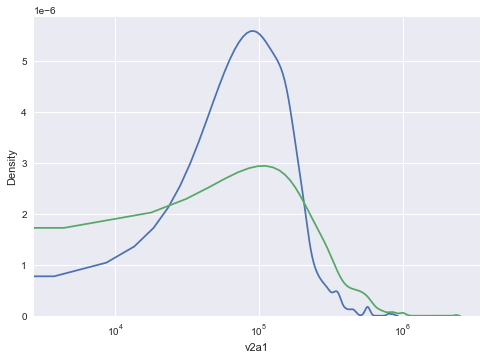

In [20]:
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 1, 'v2a1'], label='Monthly rent payment of household(rented=1)')
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 0, 'v2a1'], label='Monthly rent payment of household(rented=0)')
plt.xscale('log')
plt.show()

In [21]:
df_train['v2a1'].fillna(0, inplace=True)
df_test['v2a1'].fillna(0, inplace=True)

In [22]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,9557,100.0
Target,0,0.0
sanitario3,0,0.0
sanitario2,0,0.0
sanitario1,0,0.0
coopele,0,0.0
noelec,0,0.0
planpri,0,0.0
public,0,0.0
abastaguano,0,0.0


In [23]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,23856,100.0
abastaguano,0,0.0
sanitario2,0,0.0
sanitario1,0,0.0
coopele,0,0.0
noelec,0,0.0
planpri,0,0.0
public,0,0.0
abastaguafuera,0,0.0
sanitario5,0,0.0


### For now, there are no NaN values.

# 2. Feature engineering

## 2.1 Object features

In [24]:
features_object = [col for col in df_train.columns if df_train[col].dtype == 'object']

In [25]:
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

### dependecy

In [26]:
# some dependencies are Na, fill those with the square root of the square
df_train['dependency'] = np.sqrt(df_train['SQBdependency'])
df_test['dependency'] = np.sqrt(df_test['SQBdependency'])

### edjefe
- edjefe, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- replace yes -> 1 and no -> 0

In [27]:
def replace_edjefe(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefe'] = df_train['edjefe'].apply(replace_edjefe).astype(float)
df_test['edjefe'] = df_test['edjefe'].apply(replace_edjefe).astype(float)

### edjefa

- edjefa, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- replace yes -> 1 and no -> 0

In [28]:
def replace_edjefa(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefa'] = df_train['edjefa'].apply(replace_edjefa).astype(float)
df_test['edjefa'] = df_test['edjefa'].apply(replace_edjefa).astype(float)

In [29]:
# create feature with max education of either head of household
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

## roof and electricity
- I refered to https://www.kaggle.com/mineshjethva/exploratory-data-analysis-lightgbm. Thanks!

In [30]:
df_train['roof_waste_material'] = np.nan
df_test['roof_waste_material'] = np.nan
df_train['electricity_other'] = np.nan
df_test['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0

df_train['roof_waste_material'] = df_train.apply(lambda x : fill_roof_exception(x),axis=1)
df_test['roof_waste_material'] = df_test.apply(lambda x : fill_roof_exception(x),axis=1)
df_train['electricity_other'] = df_train.apply(lambda x : fill_no_electricity(x),axis=1)
df_test['electricity_other'] = df_test.apply(lambda x : fill_no_electricity(x),axis=1)

## 2.2 Extract cat features
- According to data scription, there are many binary category features.

In [31]:
binary_cat_features = [col for col in df_train.columns if df_train[col].value_counts().shape[0] == 2]

## 2.3 Make new features using continuous feature

In [32]:
continuous_features = [col for col in df_train.columns if col not in binary_cat_features]
continuous_features = [col for col in continuous_features if col not in features_object]
continuous_features = [col for col in continuous_features if col not in ['Id', 'Target', 'idhogar']]

In [33]:
print('There are {} continuous features'.format(len(continuous_features)))
for col in continuous_features:
    print('{}: {}'.format(col, description.loc[description['varname'] == col, 'description'].values))

There are 37 continuous features
v2a1: [' Monthly rent payment']
rooms: ['  number of all rooms in the house']
v18q1: [' number of tablets household owns']
r4h1: [' Males younger than 12 years of age']
r4h2: [' Males 12 years of age and older']
r4h3: [' Total males in the household']
r4m1: [' Females younger than 12 years of age']
r4m2: [' Females 12 years of age and older']
r4m3: [' Total females in the household']
r4t1: [' persons younger than 12 years of age']
r4t2: [' persons 12 years of age and older']
r4t3: [' Total persons in the household']
tamhog: [' size of the household']
tamviv: [' number of persons living in the household']
escolari: [' years of schooling']
rez_esc: [' Years behind in school']
hhsize: [' household size']
elimbasu5: [' =1 if rubbish disposal mainly by throwing in river,   creek or sea']
hogar_nin: [' Number of children 0 to 19 in household']
hogar_adul: [' Number of adults in household']
hogar_mayor: [' # of individuals 65+ in the household']
hogar_total: [

- hhsize : household size
- tamhog : size of the household

What is different?

- As you can see, the meaning of two features are same but the exact number are different. Are they different?
- I don't know.  For now, I decided to drop one feature 'tamhog'.

In [34]:
df_train['edjef'].value_counts()

6.0     2792
11.0    1150
9.0      723
8.0      474
15.0     473
3.0      459
0.0      435
7.0      413
4.0      400
5.0      398
14.0     328
17.0     278
2.0      278
16.0     247
10.0     207
12.0     185
13.0     155
1.0       65
21.0      48
18.0      22
19.0      18
20.0       9
Name: edjef, dtype: int64

In [35]:
df_train.drop('tamhog', axis=1, inplace=True)
df_test.drop('tamhog', axis=1, inplace=True)

### Squared features

-  There are many squared features. Actually, tree models like lightgbm don't need them. But at this kernel, I want to use lightgbm as feature filter model and set entity- embedding as classfier. So Let's keep them.

### Family features
- hogar_nin, hogar_adul, hogar_mayor, hogar_total, r4h1, r4h2, r4h3, r4m1, r4m2, r4m3, r4t1, r4t2, r4t3, tmbhog, tamvid, rez_esc, escolari

- Family size features (substract, ratio)

In [36]:
df_train['adult'] = df_train['hogar_adul'] - df_train['hogar_mayor']
df_train['dependency_count'] = df_train['hogar_nin'] + df_train['hogar_mayor']
df_train['dependency'] = df_train['dependency_count'] / df_train['adult']
df_train['child_percent'] = df_train['hogar_nin'] / df_train['hogar_total']
df_train['elder_percent'] = df_train['hogar_mayor'] / df_train['hogar_total']
df_train['adult_percent'] = df_train['hogar_adul'] / df_train['hogar_total']
df_train['males_younger_12_years_percent'] = df_train['r4h1'] / df_train['hogar_total']
df_train['males_older_12_years_percent'] = df_train['r4h2'] / df_train['hogar_total']
df_train['males_percent'] = df_train['r4h3'] / df_train['hogar_total']
df_train['females_younger_12_years_percent'] = df_train['r4m1'] / df_train['hogar_total']
df_train['females_older_12_years_percent'] = df_train['r4m2'] / df_train['hogar_total']
df_train['females_percent'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_percent'] = df_train['r4t1'] / df_train['hogar_total']
df_train['persons_older_12_years_percent'] = df_train['r4t2'] / df_train['hogar_total']
df_train['persons_percent'] = df_train['r4t3'] / df_train['hogar_total']

In [37]:
df_test['adult'] = df_test['hogar_adul'] - df_test['hogar_mayor']
df_test['dependency_count'] = df_test['hogar_nin'] + df_test['hogar_mayor']
df_test['dependency'] = df_test['dependency_count'] / df_test['adult']
df_test['child_percent'] = df_test['hogar_nin'] / df_test['hogar_total']
df_test['elder_percent'] = df_test['hogar_mayor'] / df_test['hogar_total']
df_test['adult_percent'] = df_test['hogar_adul'] / df_test['hogar_total']
df_test['males_younger_12_years_percent'] = df_test['r4h1'] / df_test['hogar_total']
df_test['males_older_12_years_percent'] = df_test['r4h2'] / df_test['hogar_total']
df_test['males_percent'] = df_test['r4h3'] / df_test['hogar_total']
df_test['females_younger_12_years_percent'] = df_test['r4m1'] / df_test['hogar_total']
df_test['females_older_12_years_percent'] = df_test['r4m2'] / df_test['hogar_total']
df_test['females_percent'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_percent'] = df_test['r4t1'] / df_test['hogar_total']
df_test['persons_older_12_years_percent'] = df_test['r4t2'] / df_test['hogar_total']
df_test['persons_percent'] = df_test['r4t3'] / df_test['hogar_total']

In [38]:
df_train['males_younger_12_years_in_household_size'] = df_train['r4h1'] / df_train['hhsize']
df_train['males_older_12_years_in_household_size'] = df_train['r4h2'] / df_train['hhsize']
df_train['males_in_household_size'] = df_train['r4h3'] / df_train['hhsize']
df_train['females_younger_12_years_in_household_size'] = df_train['r4m1'] / df_train['hhsize']
df_train['females_older_12_years_in_household_size'] = df_train['r4m2'] / df_train['hhsize']
df_train['females_in_household_size'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_in_household_size'] = df_train['r4t1'] / df_train['hhsize']
df_train['persons_older_12_years_in_household_size'] = df_train['r4t2'] / df_train['hhsize']
df_train['persons_in_household_size'] = df_train['r4t3'] / df_train['hhsize']

In [39]:
df_test['males_younger_12_years_in_household_size'] = df_test['r4h1'] / df_test['hhsize']
df_test['males_older_12_years_in_household_size'] = df_test['r4h2'] / df_test['hhsize']
df_test['males_in_household_size'] = df_test['r4h3'] / df_test['hhsize']
df_test['females_younger_12_years_in_household_size'] = df_test['r4m1'] / df_test['hhsize']
df_test['females_older_12_years_in_household_size'] = df_test['r4m2'] / df_test['hhsize']
df_test['females_in_household_size'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_in_household_size'] = df_test['r4t1'] / df_test['hhsize']
df_test['persons_older_12_years_in_household_size'] = df_test['r4t2'] / df_test['hhsize']
df_test['persons_in_household_size'] = df_test['r4t3'] / df_test['hhsize']

In [40]:
df_train['overcrowding_room_and_bedroom'] = (df_train['hacdor'] + df_train['hacapo'])/2
df_test['overcrowding_room_and_bedroom'] = (df_test['hacdor'] + df_test['hacapo'])/2

In [41]:
df_train['escolari_age'] = df_train['escolari']/df_train['age']
df_test['escolari_age'] = df_test['escolari']/df_test['age']

df_train['age_12_19'] = df_train['hogar_nin'] - df_train['r4t1']
df_test['age_12_19'] = df_test['hogar_nin'] - df_test['r4t1']  

In [42]:
df_train['phones-per-capita'] = df_train['qmobilephone'] / df_train['tamviv']
df_train['tablets-per-capita'] = df_train['v18q1'] / df_train['tamviv']
df_train['rooms-per-capita'] = df_train['rooms'] / df_train['tamviv']
df_train['rent-per-capita'] = df_train['v2a1'] / df_train['tamviv']

In [43]:
df_test['phones-per-capita'] = df_test['qmobilephone'] / df_test['tamviv']
df_test['tablets-per-capita'] = df_test['v18q1'] / df_test['tamviv']
df_test['rooms-per-capita'] = df_test['rooms'] / df_test['tamviv']
df_test['rent-per-capita'] = df_test['v2a1'] / df_test['tamviv']

- You can see that "Total persons in the household" !=  "# of total individuals in the household". 
- Somewhat weired. But for now I will keep it. 

In [44]:
(df_train['hogar_total'] == df_train['r4t3']).sum()

9509

### Rent per  family features

- I will reduce the number of features using shap, so let's generate many features!! Hope catch some fortune features :)

In [45]:
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v2a1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v2a1'] / df_train[col]
    df_test[new_col_name] = df_test['v2a1'] / df_test[col]

- Ratio feature can have infinite values. So Let them be filled with 0

In [46]:
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

### Room per family features

In [47]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rooms'] / df_train[col]
    df_test[new_col_name] = df_test['rooms'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

### BedRoom per family features

In [48]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('bedrooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['bedrooms'] / df_train[col]
    df_test[new_col_name] = df_test['bedrooms'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [49]:
print(df_train.shape, df_test.shape) # To check the same number of features between train and test (target is there in train)

(9557, 220) (23856, 219)


### Tabulet per family features

In [50]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v18q1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v18q1'] / df_train[col]
    df_test[new_col_name] = df_test['v18q1'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

### phone per family features

In [51]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('qmobilephone', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['qmobilephone'] / df_train[col]
    df_test[new_col_name] = df_test['qmobilephone'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

### rez_esc(Years behind in school)  per family features 

In [52]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rez_esc', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rez_esc'] / df_train[col]
    df_test[new_col_name] = df_test['rez_esc'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [53]:
df_train['rez_esc_age'] = df_train['rez_esc'] / df_train['age']
df_train['rez_esc_escolari'] = df_train['rez_esc'] / df_train['escolari']

df_test['rez_esc_age'] = df_test['rez_esc'] / df_test['age']
df_test['rez_esc_escolari'] = df_test['rez_esc'] / df_test['escolari']

### Rich features
- I think the more richer, the larger number of phones and tabulet

In [54]:
df_train['tabulet_x_qmobilephone'] = df_train['v18q1'] * df_train['qmobilephone']
df_test['tabulet_x_qmobilephone'] = df_test['v18q1'] * df_test['qmobilephone']

- wall, roof, floor may be key factor.
- Let's multiply each of them. Becuase they are binary cat features, so mulitification of each features generates new categorical features

In [55]:
# wall and roof
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
# wall and floor
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

# roof and floor
for col1 in ['etecho1', 'etecho2', 'etecho3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

- combination using three features

In [56]:
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        for col3 in ['eviv1', 'eviv2', 'eviv3']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [57]:
print(df_train.shape, df_test.shape)

(9557, 322) (23856, 321)


- I want to mix electricity and energy features -> energy features

In [58]:
for col1 in ['public', 'planpri', 'noelec', 'coopele']:
    for col2 in ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

- I want to mix toilet and rubbish disposal features -> other_infra features

In [59]:
for col1 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
    for col2 in ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

- I want to mix toilet and water provision features -> water features

In [60]:
for col1 in ['abastaguadentro', 'abastaguafuera', 'abastaguano']:
    for col2 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [61]:
print(df_train.shape, df_test.shape)

(9557, 383) (23856, 382)


- I want mix education and area features -> education_zone_features

In [62]:
for col1 in ['area1', 'area2']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

- Mix region and education

In [63]:
for col1 in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [64]:
print(df_train.shape, df_test.shape)

(9557, 455) (23856, 454)


- Multiply television / mobilephone / computer / tabulet / refrigerator -> electornics features

In [65]:
df_train['electronics'] = df_train['computer'] * df_train['mobilephone'] * df_train['television'] * df_train['v18q'] * df_train['refrig']
df_test['electronics'] = df_test['computer'] * df_test['mobilephone'] * df_test['television'] * df_test['v18q'] * df_test['refrig']

df_train['no_appliances'] = df_train['refrig'] + df_train['computer'] + df_train['television'] + df_train['mobilephone']
df_test['no_appliances'] = df_test['refrig'] + df_test['computer'] + df_test['television'] + df_test['mobilephone']

- Mix wall material of roof, floor, wall

In [66]:
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

for col1 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
    for col1 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]        
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        for col3 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [67]:
print(df_train.shape, df_test.shape)

(9557, 733) (23856, 732)


- Wow! without any aggreation features, we hvae 446 features for now. Actually mixing the materials of walls make thousands of features. I don't want to do that because of computational costs!

### Remove feature with only one value

In [68]:
cols_with_only_one_value = []
for col in df_train.columns:
    if col == 'Target':
        continue
    if df_train[col].value_counts().shape[0] == 1 or df_test[col].value_counts().shape[0] == 1:
        print(col)
        cols_with_only_one_value.append(col)

elimbasu5
new_planpri_x_energcocinar1
new_planpri_x_energcocinar2
new_planpri_x_energcocinar3
new_planpri_x_energcocinar4
new_noelec_x_energcocinar2
new_sanitario1_x_elimbasu4
new_sanitario1_x_elimbasu5
new_sanitario1_x_elimbasu6
new_sanitario2_x_elimbasu4
new_sanitario2_x_elimbasu5
new_sanitario2_x_elimbasu6
new_sanitario3_x_elimbasu5
new_sanitario5_x_elimbasu4
new_sanitario5_x_elimbasu5
new_sanitario5_x_elimbasu6
new_sanitario6_x_elimbasu2
new_sanitario6_x_elimbasu4
new_sanitario6_x_elimbasu5
new_sanitario6_x_elimbasu6
new_abastaguafuera_x_sanitario6
new_abastaguano_x_sanitario2
new_abastaguano_x_sanitario6
new_paredblolad_x_pisonatur
new_paredblolad_x_pisonotiene
new_paredzocalo_x_pisoother
new_paredzocalo_x_pisonatur
new_paredpreb_x_pisonatur
new_pareddes_x_pisoother
new_pareddes_x_pisonatur
new_paredmad_x_pisoother
new_paredmad_x_pisonatur
new_paredzinc_x_pisoother
new_paredzinc_x_pisonatur
new_paredfibras_x_pisoother
new_paredfibras_x_pisonatur
new_paredfibras_x_pisonotiene
new_p

- Let's remove them!

In [69]:
df_train.drop(cols_with_only_one_value, axis=1, inplace=True)
df_test.drop(cols_with_only_one_value, axis=1, inplace=True)

### Check whether both train and test have same features

In [70]:
cols_train = np.array(sorted([col for col in df_train.columns if col != 'Target']))
cols_test = np.array(sorted(df_test.columns))

In [71]:
(cols_train == cols_test).sum() == len(cols_train)

True

- Good, Let's move!

## 2.4 aggregation features

- In this competition, each samples are member of spectific household(idhogar). So let's aggregate based on 'idhogar' values.

### Aggregation for family features

In [72]:
def max_min(x):
    return x.max() - x.min()

In [73]:
agg_train = pd.DataFrame()
agg_test = pd.DataFrame()

for item in tqdm(family_size_features):
    for i, function in enumerate(['mean','std','min','max','sum', 'count', max_min]):
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new_' + 'max_min'
        else:
            new_col = item + '_new_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test

print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.21it/s]

new aggregate train set has 2988 rows, and 105 features
new aggregate test set has 7352 rows, and 105 features


In [74]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']



for item in tqdm(aggr_list):
    for function in ['count', 'sum']:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        new_col = item + '_new1_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 51.44it/s]

new aggregate train set has 2988 rows, and 199 features
new aggregate test set has 7352 rows, and 199 features


In [75]:
aggr_list = ['escolari', 'age', 'escolari_age', 'dependency', 'bedrooms', 'overcrowding', 'rooms', 'qmobilephone', 'v18q1']

for item in tqdm(aggr_list):
    for function in ['mean','std','min','max','sum', 'count', max_min]:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new2_' + 'max_min'
        else:
            new_col = item + '_new2_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test

print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.12it/s]

new aggregate train set has 2988 rows, and 208 features
new aggregate test set has 7352 rows, and 208 features


In [76]:
agg_test = agg_test.reset_index()
agg_train = agg_train.reset_index()

train_agg = pd.merge(df_train, agg_train, on='idhogar')
test = pd.merge(df_test, agg_test, on='idhogar')

#fill all na as 0
train_agg.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 724) test shape: (23856, 723)


In [77]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 1006) test shape: (23856, 1005)


In [78]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 1288) test shape: (23856, 1287)


In [79]:
cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

for function in tqdm(['mean','std','min','max','sum', 'count', max_min]):
    for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
        group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_train.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_train][2:]

        group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_test.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_test][2:]

        train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
        test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
        
print('train shape:', train_agg.shape, 'test shape:', test.shape)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:00<00:00, 17.15s/it]

train shape: (9557, 3262) test shape: (23856, 3261)


- According to data descriptions,ONLY the heads of household are used in scoring. /
- All household members are included in test + the sample submission, but only heads of households are scored.

In [80]:
# household 단위로 
train = train_agg.query('parentesco1==1')

In [81]:
train['dependency'].replace(np.inf, 0, inplace=True)
test['dependency'].replace(np.inf, 0, inplace=True)

In [82]:
submission = test[['Id']]

#Remove useless feature to reduce dimension
train.drop(columns=['idhogar','Id', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test.drop(columns=['idhogar','Id',  'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)

In [83]:
print('final_data size', train.shape, test.shape)

final_data size (2973, 3250) (23856, 3249)


In [84]:
print(f'The most 20 positive feature: \n{correlation.head(40)}')

The most 20 positive feature: 
Target                                1.000000
new5_lugar5_idhogar_edjef_max         0.334254
new5_lugar1_idhogar_edjef_max         0.334254
new5_lugar6_idhogar_edjef_max         0.334254
new5_lugar2_idhogar_edjef_max         0.334254
new5_lugar4_idhogar_edjef_max         0.334254
new5_lugar3_idhogar_edjef_max         0.334254
new5_lugar2_idhogar_edjef_mean        0.333873
new5_lugar4_idhogar_edjef_mean        0.333873
new5_lugar5_idhogar_edjef_mean        0.333873
new5_lugar3_idhogar_edjef_mean        0.333873
new5_lugar1_idhogar_edjef_mean        0.333873
new5_lugar6_idhogar_edjef_mean        0.333873
new5_lugar2_idhogar_edjef_min         0.333791
edjef                                 0.333791
new5_lugar5_idhogar_edjef_min         0.333791
new5_lugar6_idhogar_edjef_min         0.333791
new5_lugar1_idhogar_edjef_min         0.333791
new5_lugar4_idhogar_edjef_min         0.333791
new5_lugar3_idhogar_edjef_min         0.333791
escolari                     

In [85]:
print(f'The most 20 negative feature: \n{correlation.tail(20)}')

The most 20 negative feature: 
new5_lugar5_idhogar_television_<function max_min at 0x000001CF8FA73D30>    NaN
new5_lugar5_idhogar_mobilephone_<function max_min at 0x000001CF8FA73D30>   NaN
new5_lugar5_idhogar_area1_<function max_min at 0x000001CF8FA73D30>         NaN
new5_lugar5_idhogar_area2_<function max_min at 0x000001CF8FA73D30>         NaN
new5_lugar5_idhogar_v18q_<function max_min at 0x000001CF8FA73D30>          NaN
new5_lugar6_idhogar_epared1_<function max_min at 0x000001CF8FA73D30>       NaN
new5_lugar6_idhogar_epared2_<function max_min at 0x000001CF8FA73D30>       NaN
new5_lugar6_idhogar_epared3_<function max_min at 0x000001CF8FA73D30>       NaN
new5_lugar6_idhogar_etecho1_<function max_min at 0x000001CF8FA73D30>       NaN
new5_lugar6_idhogar_etecho2_<function max_min at 0x000001CF8FA73D30>       NaN
new5_lugar6_idhogar_etecho3_<function max_min at 0x000001CF8FA73D30>       NaN
new5_lugar6_idhogar_eviv1_<function max_min at 0x000001CF8FA73D30>         NaN
new5_lugar6_idhogar_e

# 4. Feature Selection: SHAP
 1. Stratified KFold를 이용해 각 폴드마다 LGBMClassifier 학습 후 얻은 feature importance, shap values 저장
 2. 각 폴드에서 얻은 shap_values의 평균 계산

In [86]:
binary_cat_features = [col for col in train.columns if train[col].value_counts().shape[0] == 2]
object_features = ['edjefe', 'edjefa']

categorical_feats = binary_cat_features + object_features

In [87]:
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

In [88]:
y = train['Target']
train.drop(columns=['Target'], inplace=True)

In [95]:
def extract_good_features_using_shap_LGB(params, SEED):
    clf = lgb.LGBMClassifier(objective = 'multiclass',
                             random_state = 0,
                             max_depth = params['max_depth'],
                             learning_rate = params['learning_rate'],  
                             silent = True, 
                             metric = 'multi_logloss',
                             n_jobs = -1, n_estimators = 10000, 
                             class_weight = 'balanced',
                             colsample_bytree = params['colsample_bytree'], 
                             min_split_gain= params['min_split_gain'], 
                             bagging_freq = params['bagging_freq'],
                             min_child_weight = params['min_child_weight'],
                             num_leaves = params['num_leaves'], 
                             subsample = params['subsample'],
                             reg_alpha = params['reg_alpha'],
                             reg_lambda = params['reg_lambda'],
                             num_class=len(np.unique(y)),
                             bagging_seed=SEED,
                             seed=SEED,
                            )
    
    kfold = 5
    kf = StratifiedKFold(n_splits = kfold, shuffle = True)
    feat_imp_df = pd.DataFrame()
    
    for i, (train_idx, val_idx) in enumerate(kf.split(train, y)):
        print('='*30, '{} of {} folds'.format(i+1, kfold), '='*30)
        start = time.time()
        X_train, X_val = train.iloc[train_idx], train.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], eval_metric = evaluate_macroF1_lgb,
               categorical_feature = categorical_feats, early_stopping_rounds = 500, verbose = 500)
        
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        fold_imp_df = pd.DataFrame()
        fold_imp_df['feature'] = X_train.columns
        fold_imp_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0)) # ?
        fold_imp_df['feat_imp'] = clf.feature_importances_
        feat_imp_df = pd.concat([feat_imp_df, fold_imp_df])
        
    feat_imp_df_shap = feat_imp_df.groupby('feature').mean().sort_values('shap_values', ascending = False).reset_index()
    feat_imp = feat_imp_df.groupby('feature').mean().sort_values('feat_imp', ascending = False).reset_index()
    
    return feat_imp, feat_imp_df_shap

In [96]:
total_shap_df = pd.DataFrame()
NUM_ITERATIONS = 1
for SEED in range(NUM_ITERATIONS):
    print('#'*40, '{} of {} iterations'.format(SEED+1, NUM_ITERATIONS), '#' * 40)
    params = {'max_depth': np.random.choice([5, 6, 7, 8, 10, 12, -1]),
             'learning_rate': np.random.rand() * 0.02,
              'colsample_bytree': np.random.rand() * (1 - 0.5) + 0.5,
              'subsample': np.random.rand() * (1 - 0.5) + 0.5,
              'min_split_gain': np.random.rand() * 0.2,
              'num_leaves': np.random.choice([32, 48, 64]),
              'reg_alpha': np.random.rand() * 2,
              'reg_lambda': np.random.rand() *2,
              'bagging_freq': np.random.randint(4) +1,
              'min_child_weight': np.random.randint(100) + 20
             }
    temp_feat_imp, temp_shap_df = extract_good_features_using_shap_LGB(params, SEED)
    total_shap_df = pd.concat([total_shap_df, temp_shap_df])

######################################## 1 of 1 iterations ########################################
============================== 1 of 5 folds ==============================
[LightGBM] [Warning] seed is set=0, random_state=0 will be ignored. Current value: seed=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 1.09837	training's macroF1: 0.494424	valid_1's multi_logloss: 1.0366	valid_1's macroF1: 0.41781
[1000]	training's multi_logloss: 1.03418	training's macroF1: 0.526454	valid_1's multi_logloss: 1.01674	valid_1's macroF1: 0.425921
Early stopping, best iteration is:
[552]	training's multi_logloss: 1.08963	training's macroF1: 0.50482	valid_1's multi_logloss: 1.03056	valid_1's macroF1: 0.431643
============================== 2 of 5 folds ==============================
[LightGBM] [Warning] seed is set=0, random_state=0 will be ignored.

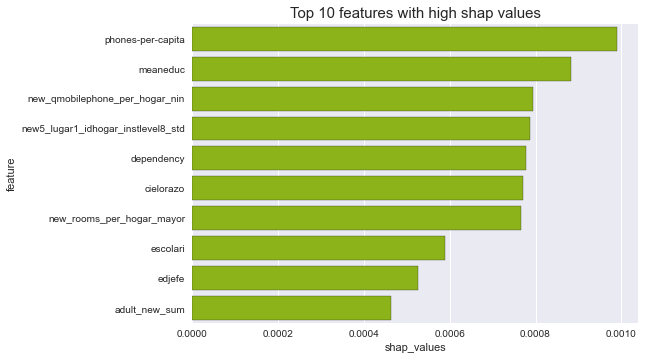

In [113]:
temp_shap_df = temp_shap_df[:10]

sns.barplot(x = temp_shap_df['shap_values'], y = temp_shap_df['feature'], color = '#99cc00', edgecolor = 'k')
plt.title('Top 10 features with high shap values', fontsize = 15)
plt.show()

In [133]:
train['phones-per-capita']

0       1.000000
1       1.000000
2       0.000000
5       0.750000
8       0.250000
          ...   
9535    0.400000
9541    0.400000
9545    0.428571
9551    1.000000
9552    0.600000
Name: phones-per-capita, Length: 2973, dtype: float64

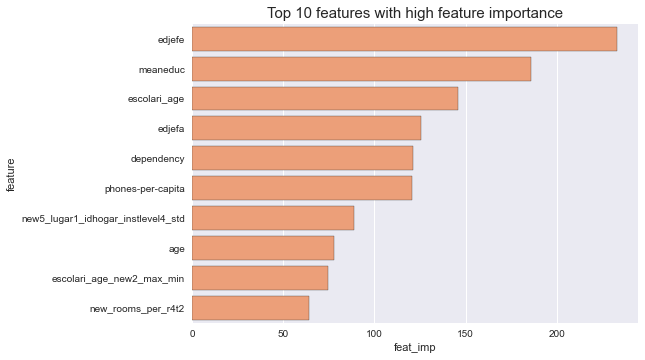

In [114]:
temp_feat_imp = temp_feat_imp[:10]

sns.barplot(x = temp_feat_imp['feat_imp'], y = temp_feat_imp['feature'], color = '#ff9966', edgecolor = 'k')
plt.title('Top 10 features with high feature importance', fontsize = 15)
plt.show()

In [116]:
shap_sorted_df = total_shap_df.groupby('feature').mean().sort_values('shap_values', ascending = False).reset_index()
feat_imp_sorted_df = total_shap_df.groupby('feature').mean().sort_values('feat_imp', ascending = False).reset_index()

feats_top_shap = shap_sorted_df['feature'][:500]
feats_top_feat_imp = shap_sorted_df['feature'][:500]

top_features = pd.Series(feats_top_shap.tolist() + feats_top_feat_imp.tolist())
top_features = top_features.unique()

# 5. Model development
 + shap value 기반으로 선택된 feature들에 대해 모델 학습 + 파라미터 튜닝 진행

In [117]:
new_train = train[top_features].copy()
new_test = test[top_features].copy()

print(new_train.shape)
print(new_test.shape)

(2973, 500)
(23856, 500)


In [118]:
new_categorical_feats = [col for col in top_features if col in categorical_feats]

## Randomized Search
 + Optimal parameter search with randomized search method

In [ ]:
optimized_param = None
lowest_cv = 1000
total_iteration = 10

for i in range(total_iteration):
    print('-'*20, 'For {} of {} iterations'.format(i+1, total_iteration), '-'*20)
    learning_rate = np.random.rand()*0.02
    n_folds = 3
    num_classes = 4
    
    params = {}
    params['objective'] = 'multiclass'
    params['metric'] = 'multi_logloss'
    params['num_class'] = num_classes
    params['class_weight'] = 'balanced'
    params['num_leaves'] = np.random.randint(24, 48)
    params['max_depth'] = np.random.randint(5, 8)
    params['min_child_weight'] = np.random.randint(5, 50)
    params['min_split_gain'] = np.random.rand() * 0.09
    params['colsample_bytree'] = np.random.rand() * (0.9 - 0.1) + 0.1
    params['subsample'] = np.random.rand() * (1 - 0.8) + 0.8
    params['bagging_freq'] = np.random.randint(1, 5)
    params['bagging_seed'] = np.random.randint(1, 5)
    params['reg_alpha'] = np.random.rand() * 2
    params['reg_lambda'] = np.random.rand() * 2
    params['learning_rate'] = np.random.rand() * 0.02
    params['force_col_wise'] = True,
    params['seed']  =1989
    
    d_train = lgb.Dataset(data = new_train, label = y.values-1, categorical_feature = new_categorical_feats, free_raw_data = False)
    cv_results = lgb.cv(params = params, train_set = d_train, num_boost_round = 10000, categorical_feature = new_categorical_feats,
                       nfold = n_folds, stratified = True, early_stopping_rounds = 10, verbose_eval = 1000, shuffle = True)
    
    min_cv_results = min(cv_results['multi_logloss-mean'])
    
    if min_cv_results < lowest_cv:
        lowest_cv = min_cv_results
        optimized_param = params

In [123]:
optimized_param

{'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_class': 4,
 'class_weight': 'balanced',
 'num_leaves': 37,
 'max_depth': 6,
 'min_child_weight': 22,
 'min_split_gain': 0.042718548756839725,
 'colsample_bytree': 0.35320780491024584,
 'subsample': 0.95189457680524,
 'bagging_freq': 4,
 'bagging_seed': 3,
 'reg_alpha': 1.2424868330616559,
 'reg_lambda': 1.1523627921268806,
 'learning_rate': 0.004241558020942351,
 'force_col_wise': (True,),
 'seed': 1989}

 + StratifiedKFold 진행하여 각 폴드마다 test set에 대한 예측 

In [124]:
def LGB_OOF(params, categorical_feats, N_FOLDs, SEED=1989):
    clf = lgb.LGBMClassifier(objective='multiclass',
                             random_state=1989,
                             max_depth=params['max_depth'], 
                             learning_rate=params['learning_rate'],  
                             silent=True, 
                             metric='multi_logloss',
                             n_jobs=-1, n_estimators=10000, 
                             class_weight='balanced',
                             colsample_bytree = params['colsample_bytree'], 
                             min_split_gain= params['min_split_gain'], 
                             bagging_freq = params['bagging_freq'],
                             min_child_weight=params['min_child_weight'],
                             num_leaves = params['num_leaves'], 
                             subsample = params['subsample'],
                             reg_alpha= params['reg_alpha'],
                             reg_lambda= params['reg_lambda'],
                             num_class=len(np.unique(y)),
                             bagging_seed=SEED,
                             seed=SEED,
                            )

    kfold = 5
    kf = StratifiedKFold(n_splits = kfold, shuffle = True)
    feat_importance_df  = pd.DataFrame()
    predicts_result = []

    for i, (train_index, test_index) in enumerate(kf.split(new_train, y)):
        print('='*30, '{} of {} folds'.format(i+1, kfold), '='*30)
        start = time.time()
        X_train, X_val = new_train.iloc[train_index], new_train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], 
                eval_metric = evaluate_macroF1_lgb,categorical_feature = new_categorical_feats,
                early_stopping_rounds = 500, verbose = 500)
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        fold_importance_df['feat_imp'] = clf.feature_importances_
        feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
        
        # 각 fold마다 prediction 한 값 저장
        predicts_result.append(clf.predict(new_test))
        #print_execution_time(start)
    return predicts_result, feat_importance_df

In [125]:
predicts_result, feat_importance_df = LGB_OOF(optimized_param, new_categorical_feats, 5, SEED = 0)

============================== 1 of 5 folds ==============================
[LightGBM] [Warning] seed is set=0, random_state=1989 will be ignored. Current value: seed=0
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 500 rounds
[500]	training's multi_logloss: 0.913203	training's macroF1: 0.660606	valid_1's multi_logloss: 1.05297	valid_1's macroF1: 0.388217
Early stopping, best iteration is:
[380]	training's multi_logloss: 0.975038	training's macroF1: 0.64271	valid_1's multi_logloss: 1.07613	valid_1's macroF1: 0.403319
============================== 2 of 5 folds ==============================
[LightGBM] [Warning] seed is set=0, random_state=1989 will be ignored. Current value: seed=0
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 500 rounds
[500]	training's multi_loglo

In [126]:
predicts_result

[array([4, 4, 4, ..., 2, 2, 2], dtype=int64),
 array([4, 4, 4, ..., 2, 2, 2], dtype=int64),
 array([4, 4, 4, ..., 2, 2, 2], dtype=int64),
 array([4, 4, 4, ..., 2, 2, 2], dtype=int64),
 array([4, 4, 4, ..., 2, 2, 2], dtype=int64)]